#Character Level GPT trained on Shakespeare Data

In [ ]:
!pip install torchvision


Step 1: Load the Shakespeare data and preview first 500 characters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


file_path = "input.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

print(f"Total characters in dataset: {len(text)}")
print(f"Sample text:\n{text[:500]}")


Total characters in dataset: 1115394
Sample text:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


Step 2: Tokenize at char level, get all unique characters and create mappings for char to index and vice vera.

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

print(f"Vocabulary Size: {vocab_size}")
print(f"Character Mappings:\n{char_to_idx}")


Vocabulary Size: 65
Character Mappings:
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


Srep 3: convert text to integer and print first 100 encided characters

In [ ]:

encoded_text = np.array([char_to_idx[c] for c in text], dtype=np.int32)

print(f"Encoded text sample: {encoded_text[:100]}")


Encoded text sample: [18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]


Step 4: input sequence with length 125 tokens, with step = 1 the next sequence will be generated from the previous sequence with a shift of 1 token

In [ ]:
seq_length = 125
step = 1
sequences = []
targets = []

for i in range(0, len(encoded_text) - seq_length, step):
    sequences.append(encoded_text[i:i + seq_length])
    targets.append(encoded_text[i + 1:i + seq_length + 1])  # Full sequence shifted by 1

X = torch.tensor(sequences, dtype=torch.long)
y = torch.tensor(targets, dtype=torch.long)
print(f"Total training sequences: {X.shape[0]}")


Total training sequences: 1115269


/tmp/ipykernel_22526/104445801.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.tensor(sequences, dtype=torch.long)


In [ ]:
!pip install scikit-learn

Step 5: Split the dataset into 80% training and 20% validation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")


Training set size: 892215, Validation set size: 223054


Step 6: TransformerBlock with GELU activation gave a better result than RELU

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.2):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),  # Changed from ReLU to GELU
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        norm_x = self.norm1(x)
        attn_output, _ = self.attention(norm_x, norm_x, norm_x, attn_mask=mask)
        x = x + self.dropout(attn_output)

        norm_x = self.norm2(x)
        ff_output = self.ff(norm_x)
        x = x + ff_output
        return x

Step 7: Sine and Cosine functions to create unique values for each positionin the sequence. Positional encoding helps the transformer understand position of tokens in the sequence

In [ ]:
import math

def get_positional_encoding(max_len, embed_dim):
    pe = torch.zeros(max_len, embed_dim)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)



Step 8: Various combinations of hyperparameters were tested and the following combination gave the best result on training the model

In [ ]:

class GPTCharacterModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=192, num_heads=6, ff_dim=768, num_layers=6, max_len=125, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.max_len = max_len
        self.position_embedding = get_positional_encoding(self.max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)]
        )
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def to(self, device):
        super().to(device)
        self.position_embedding = self.position_embedding.to(device)
        return self

    def forward(self, x):
        batch_size, seq_len = x.shape

        # Add positional embeddings to token embeddings
        x = self.embedding(x) + self.position_embedding[:, :seq_len, :]
        x = self.dropout(x)

        # Create causal mask, using triu to ensure each position can only attend to previous positions
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device) * float('-inf'), diagonal=1)

        x = x.permute(1, 0, 2)
        for transformer in self.transformer_blocks:
            x = transformer(x, mask)

        x = x.permute(1, 0, 2)
        x = self.norm(x)
        return self.fc(x)

Step 9: Traning function where more hyperparameters and learning rate scheduler is defined. Gradient clipping is implemented to avoid exploding gradient.  

In [ ]:
def train(model, dataloader, val_dataloader, epochs=25, lr=0.0003, warmup_steps=1000):
    embed_dim = model.embedding.embedding_dim
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        progress = float(step - warmup_steps) / float(max(1, 100000 - warmup_steps))
        return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.reshape(-1, vocab_size), y_batch.reshape(-1))
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output.reshape(-1, vocab_size), y_batch.reshape(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.7f}")

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, "best_model.pth")
            patience_counter = 0
            print(f"Model saved with improved validation loss: {avg_val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    return train_losses, val_losses

Step 10: Time for epoch runtime is printed. Intermediate results of the model are printed every 5 epochs and finally the model is saved.

In [ ]:
import time
import datetime
from pytz import timezone
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Initialize model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTCharacterModel(vocab_size).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Training on: {device}")

# Function to get current time in Pacific Time with 12-hour format
def get_pt_time():
    pacific = timezone('US/Pacific')
    now = datetime.datetime.now(pacific)
    return now.strftime("%Y-%m-%d %I:%M:%S %p PT")

# Function to format seconds into HH:MM:SS
def format_time(seconds):
    hours, remainder = divmod(int(seconds), 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Text generation function for intermediate predictions
def generate_intermediate_text(model, start_text="The ", length=100, temperature=0.7, top_p=0.9):
    device = model.embedding.weight.device
    model.eval()

    # Handle potential unknown characters in start text
    generated = []
    for ch in start_text:
        if ch in char_to_idx:
            generated.append(char_to_idx[ch])
        else:
            continue

    input_seq = torch.tensor(generated, dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(length):
        with torch.no_grad():
            # Get model output for the current sequence
            output = model(input_seq)[:, -1, :] / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(output, dim=-1)

            # Nucleus (top-p) sampling
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

            # Remove tokens with cumulative probability above the threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            # Shift the indices to the right to keep the first token above the threshold
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            # Create a mask for allowed indices
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            probs = probs.masked_fill(indices_to_remove, 0.0)

            # Sample from the filtered distribution
            next_char = torch.multinomial(probs, 1).item()

            generated.append(next_char)

            # Update input sequence for next iteration
            input_seq = torch.tensor(generated[-model.max_len:], dtype=torch.long).unsqueeze(0).to(device)

    return start_text + "".join(idx_to_char[idx] for idx in generated)

# Modify train function to track time and generate sample text
def train_with_timing_and_samples(model, dataloader, val_dataloader, epochs=25, lr=0.0003, warmup_steps=1000):
    embed_dim = model.embedding.embedding_dim
    device = model.embedding.weight.device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

    # Learning rate scheduler with linear warmup and cosine decay
    def lr_lambda(step):
        # Linear warmup for warmup_steps steps
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        # Cosine learning rate decay
        progress = float(step - warmup_steps) / float(max(1, 100000 - warmup_steps))
        return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    best_val_loss = float('inf')
    patience = 25
    patience_counter = 0

    train_losses, val_losses = [], []
    total_start_time = time.time()

    # Sample prompts for consistent evaluation
    sample_prompts = [
        "Before we proceed any further, hear me speak.",
        "To be, or not to be, that is the",
        "All the world's a stage, and all the men and women merely",
        "What light through yonder window"
    ]

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)  # Shape: [batch_size, seq_length, vocab_size]
            loss = criterion(output.reshape(-1, vocab_size), y_batch.reshape(-1))  # Flatten
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output.reshape(-1, vocab_size), y_batch.reshape(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Calculate time for this epoch
        epoch_time = time.time() - epoch_start_time
        elapsed_time = time.time() - total_start_time

        # Estimate time remaining
        avg_epoch_time = elapsed_time / (epoch + 1)
        remaining_epochs = epochs - (epoch + 1)
        estimated_time_remaining = avg_epoch_time * remaining_epochs

        # Format times using custom function
        epoch_time_str = format_time(epoch_time)
        elapsed_time_str = format_time(elapsed_time)
        remaining_time_str = format_time(estimated_time_remaining)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.7f}")
        print(f"Time: {epoch_time_str} | Total: {elapsed_time_str} | Remaining: {remaining_time_str}")

        # Generate sample text every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print("\n----- SAMPLE GENERATIONS -----")
            for i, prompt in enumerate(sample_prompts):
                generated = generate_intermediate_text(model, start_text=prompt, length=50, temperature=0.7)
                print(f"Sample {i+1}: {generated}")
            print("----- END SAMPLES -----\n")

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, "best_model.pth")
            patience_counter = 0
            print(f"Model saved with improved validation loss: {avg_val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    total_time = time.time() - total_start_time
    total_time_str = format_time(total_time)
    print(f"Total training time: {total_time_str}")

    # Generate final samples
    print("\n----- FINAL GENERATIONS -----")
    for i, prompt in enumerate(sample_prompts):
        generated = generate_intermediate_text(model, start_text=prompt, length=100, temperature=0.6)
        print(f"Final Sample {i+1}: {generated}")
    print("----- END FINAL SAMPLES -----\n")

    return train_losses, val_losses

# Train with timing information and sample generation
print(f"Starting training at {get_pt_time()}")
train_losses, val_losses = train_with_timing_and_samples(model, train_loader, val_loader, epochs=40)

# Save final model
torch.save(model.state_dict(), "final_model.pth")
print(f"Training completed at {get_pt_time()}")
print("Final model saved as final_model.pth")

Total parameters: 2,694,593
Training on: cuda
Starting training at 2025-03-12 02:56:16 PM PT
Epoch 1/40, Train Loss: 1.6853, Val Loss: 1.2695, LR: 0.0002875
Time: 00:04:45 | Total: 00:04:45 | Remaining: 03:05:35

----- SAMPLE GENERATIONS -----
Sample 1: Before we proceed any further, hear me speak.Before we proceed any further, hear me speak.

BAPTISTA:
I will do the fair cannot straight the
Sample 2: To be, or not to be, that is theTo be, or not to be, that is the state of such a sea
That be murder'd by the loss 
Sample 3: All the world's a stage, and all the men and women merelyAll the world's a stage, and all the men and women merely.

DUKE OF YORK:
What she doth thou wilt for the f
Sample 4: What light through yonder windowWhat light through yonder window the more
Of a more strength to leave a blood of t
----- END SAMPLES -----

Model saved with improved validation loss: 1.2695
Epoch 2/40, Train Loss: 1.3248, Val Loss: 1.1795, LR: 0.0002487
Time: 00:04:47 | Total: 00:09:33 | Remain

Step 11: Finally the saved model is loaded, instantiated and output of length 500 is generated.

In [ ]:
import torch

# Recreate character mappings from input.txt
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()
chars = sorted(list(set(text)))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}
vocab_size = len(chars)

# Instantiate the model with the same parameters used during training
model = GPTCharacterModel(vocab_size=vocab_size, embed_dim=192, num_heads=6, ff_dim=768, num_layers=6, max_len=125, dropout=0.2)

# Load the saved state_dict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("final_model.pth", map_location=device))
model.to(device)
model.eval()

def generate_text(model, start_text, length=500, temperature=0.8, top_k=20):
    device = model.embedding.weight.device
    generated = [char_to_idx[ch] for ch in start_text if ch in char_to_idx]
    input_seq = torch.tensor(generated, dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(length):
        with torch.no_grad():
            output = model(input_seq)[:, -1, :] / temperature
            probs = torch.softmax(output, dim=-1)
            top_k_probs, top_k_ids = probs.topk(top_k, dim=-1)
            next_char_idx = torch.multinomial(top_k_probs, 1).item()
            next_char = top_k_ids[0, next_char_idx].item()
            generated.append(next_char)
            input_seq = torch.tensor(generated[-model.max_len:], dtype=torch.long).unsqueeze(0).to(device)
            if i % 50 == 0:  # Print every 50 characters
                print(f"Step {i}: {' '.join(idx_to_char[idx] for idx in generated[-50:])}")

    return "".join(idx_to_char[idx] for idx in generated)

# Test the function
start_prompt = "Before we proceed any further, hear me speak."
generated_text = generate_text(model, start_prompt, length=900)
print(f"Generated text:\n{generated_text}")

Generated text:
Before we proceed any further, hear me speak.

First Citizen:
You may peril our ears in the service of his honour,
May be but prayed with him. I forgive it to this:
I will forget such necessity of my peace
Be profess'd to me, whose sovereignty
Would send for me again.

CLAUDIO:
Then, if I cannot do.

ISABELLA:
Be gone.

LUCIO:
Ay, here comes my true service.

ANGELO:
And to see looks fell by the lower things will not do
But this restraint while he hath been feels
The heavy mother doth continue their own.

ROMEO:
In this new man that we have learn'd my brother's
Commong me to this king; and, if he cannot,
See that the heavens shall come the day of me.

BRUTUS:
How is't well?

SICINIUS:
No, no, no;
I am no tribunes: let's see the consuls in the note.

MENENIUS:
I am now too unprovided, for the suburbs of heaven
Be ran as following and in the crown?

First Senator:
So he that will be thine.

Second Murderer:
So that you do not show yo


Step 12: Train-Validation loss curve is plotted

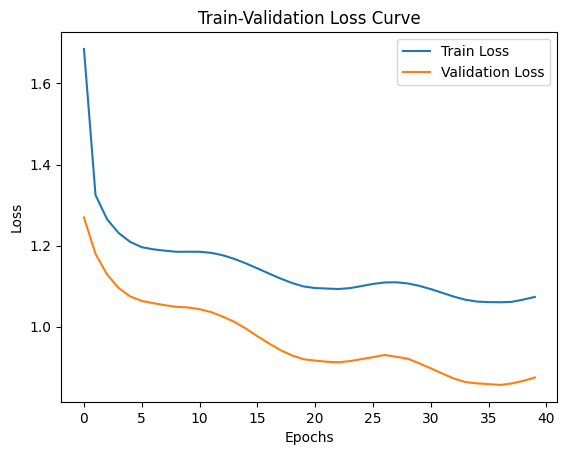

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train-Validation Loss Curve")
plt.show()
